In [22]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import matplotlib.pyplot as plt
#import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf

import pickle

In [8]:
#!pip install ucimlrepo
#!pip install seaborn

1. Date: The date when the energy usage data was recorded.
2. Time: The time when the energy usage data was recorded.
3. Global Active Power: The total amount of electrical power used by the household at that moment, measured in kilowatts (similar to the power your appliances use).
4. Global Reactive Power: The amount of electrical power that is not effectively used by your appliances but still flows through the electrical lines, measured in kilowatts.
5. Voltage: The force that pushes the electricity through the wires, measured in volts (similar to water pressure in a pipe).
6. Global Intensity: The strength of the electrical current flowing through the wires, measured in amps (similar to the flow rate of water in a pipe).
7. Sub Metering 1: The amount of electrical energy used by appliances in the kitchen, like the dishwasher, oven, and microwave, measured in watt-hours of active energy.
8. Sub Metering 2: The amount of electrical energy used by appliances in the laundry room, like the washing machine, dryer, refrigerator, and light, measured in watt-hours of active energy.
9. Sub Metering 3: The amount of electrical energy used by the water heater and air conditioner, measured in watt-hours of active energy.

## 1. Reading the dataset from:
https://archive.ics.uci.edu/dataset/235/individual+household+electric+power+consumption

In [6]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
individual_household_electric_power_consumption = fetch_ucirepo(id=235) 
  
# data (as pandas dataframes) 
X = individual_household_electric_power_consumption.data.features 
y = individual_household_electric_power_consumption.data.targets 
  
# metadata 
print(individual_household_electric_power_consumption.metadata) 
  
# variable information 
print(individual_household_electric_power_consumption.variables) 


/usr/local/lib/python3.10/site-packages/ucimlrepo/fetch.py:97: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


{'uci_id': 235, 'name': 'Individual household electric power consumption', 'repository_url': 'https://archive.ics.uci.edu/dataset/235/individual+household+electric+power+consumption', 'data_url': 'https://archive.ics.uci.edu/static/public/235/data.csv', 'abstract': 'Measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years. Different electrical quantities and some sub-metering values are available.', 'area': 'Physics and Chemistry', 'tasks': ['Regression', 'Clustering'], 'characteristics': ['Multivariate', 'Time-Series'], 'num_instances': 2075259, 'num_features': 9, 'feature_types': ['Real'], 'demographics': [], 'target_col': None, 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2006, 'last_updated': 'Tue Jan 09 2024', 'dataset_doi': '10.24432/C58K54', 'creators': ['Georges Hebrail', 'Alice Berard'], 'intro_paper': None, 'additional_info': {'summary': 'This archiv

In [7]:
data = X
data.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [11]:
print(y)

None


In [12]:
data.isna().sum()

Date                         0
Time                         0
Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64

It’s not harmful to the model if we replace these missing values with the median of the actual column values.

In [8]:
data['Sub_metering_3'].fillna(value=(data['Sub_metering_3'].mean()), inplace=True)
data.isna().sum()

/tmp/ipykernel_3711/2414499739.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Sub_metering_3'].fillna(value=(data['Sub_metering_3'].mean()), inplace=True)


Date                     0
Time                     0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


In [9]:
data[['Sub_metering_1', 'Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_2', 'Sub_metering_3']] = data[['Sub_metering_1', 'Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_2', 'Sub_metering_3']].apply(pd.to_numeric, errors='coerce')


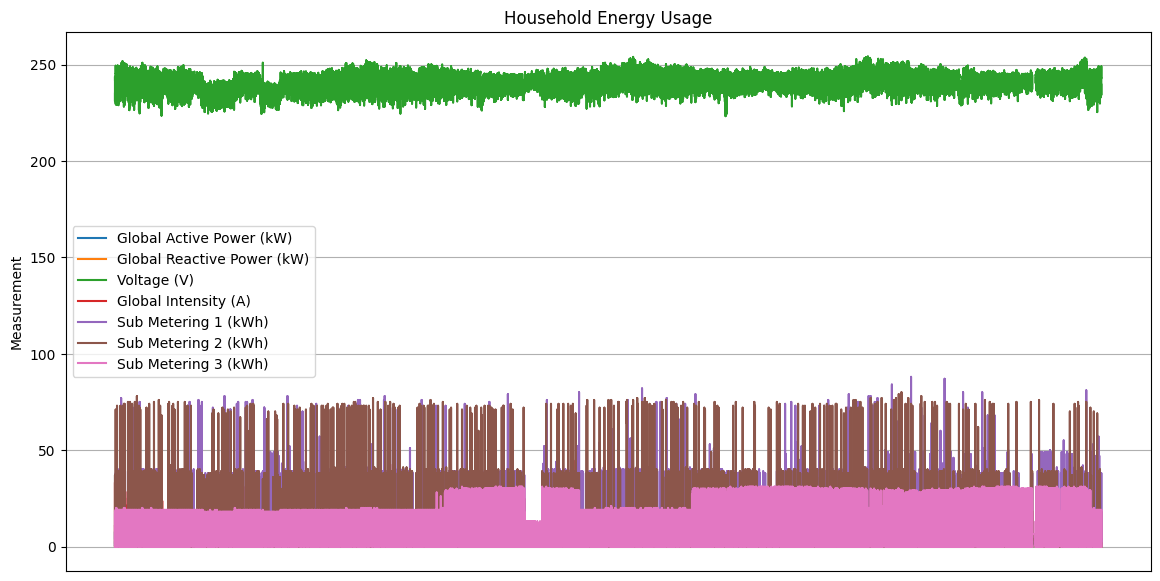

In [16]:
# Plotting the variables
plt.figure(figsize=(14, 7))

plt.plot('Date', 'Global_active_power', data= data, label='Global Active Power (kW)')
plt.plot(data['Date'], data['Global_reactive_power'], label='Global Reactive Power (kW)')
plt.plot(data['Date'], data['Voltage'], label='Voltage (V)')
plt.plot(data['Date'], data['Global_intensity'], label='Global Intensity (A)')
plt.plot(data['Date'], data['Sub_metering_1'], label='Sub Metering 1 (kWh)')
plt.plot(data['Date'], data['Sub_metering_2'], label='Sub Metering 2 (kWh)')
plt.plot(data['Date'], data['Sub_metering_3'], label='Sub Metering 3 (kWh)')

#plt.xlabel('Date')
plt.ylabel('Measurement')
plt.xticks([])  
plt.title('Household Energy Usage')
plt.legend()
plt.grid(True)
plt.show()

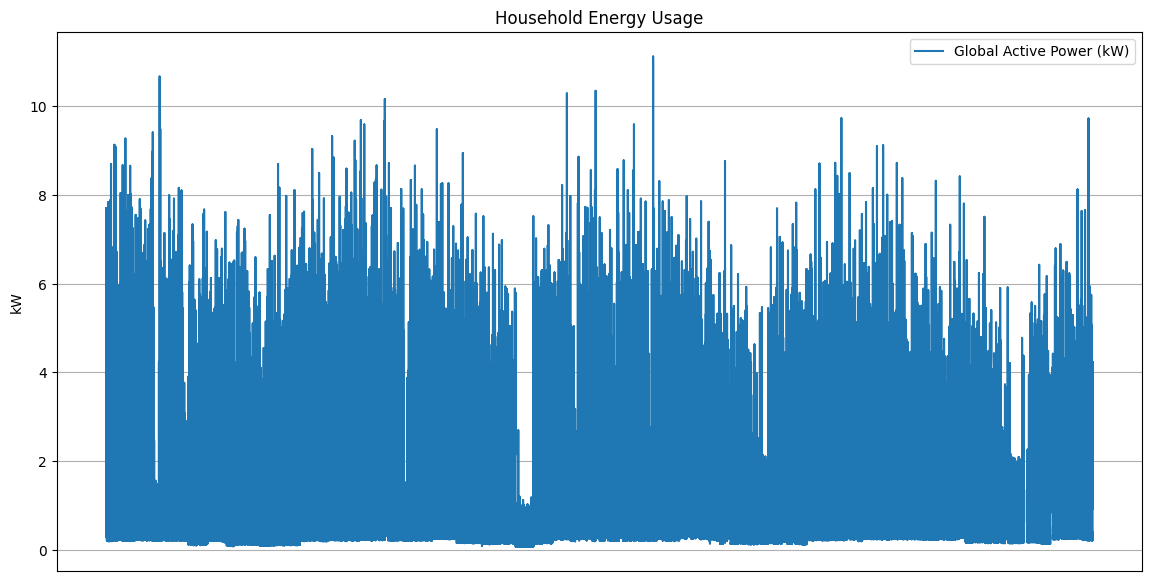

In [17]:
# Plotting the variables
plt.figure(figsize=(14, 7))

plt.plot('Date', 'Global_active_power', data= data, label='Global Active Power (kW)')

plt.ylabel('kW')
plt.xticks([])  
plt.title('Household Energy Usage')
plt.legend()
plt.grid(True)
plt.show()

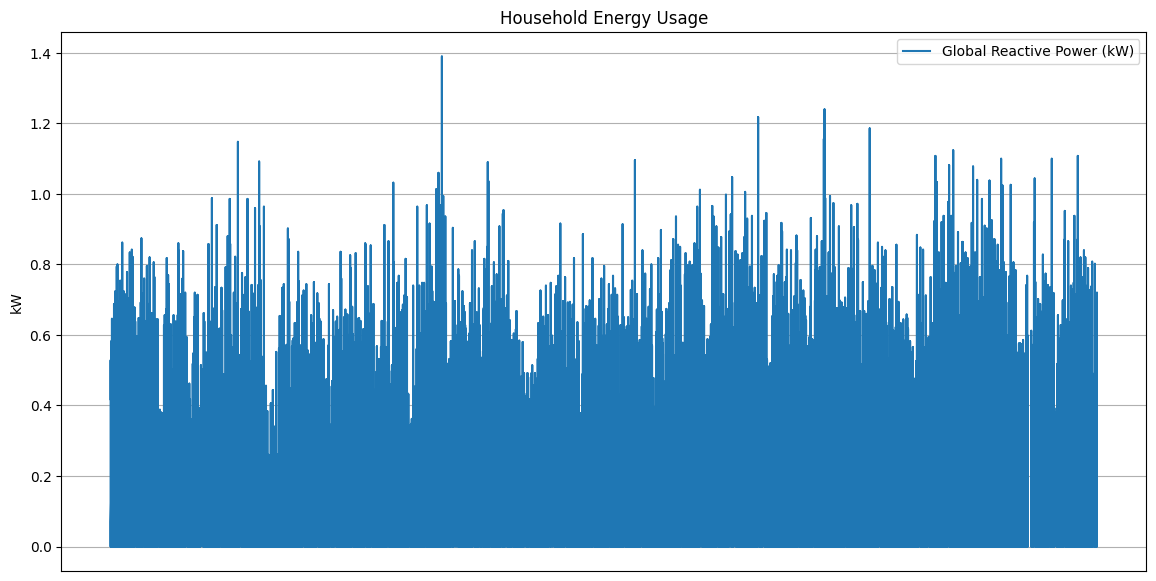

In [18]:
# Plotting the variables
plt.figure(figsize=(14, 7))

plt.plot(data['Date'], data['Global_reactive_power'], label='Global Reactive Power (kW)')

#plt.xlabel('Date')
plt.ylabel('kW')
plt.xticks([])  
plt.title('Household Energy Usage')
plt.legend()
plt.grid(True)
plt.show()

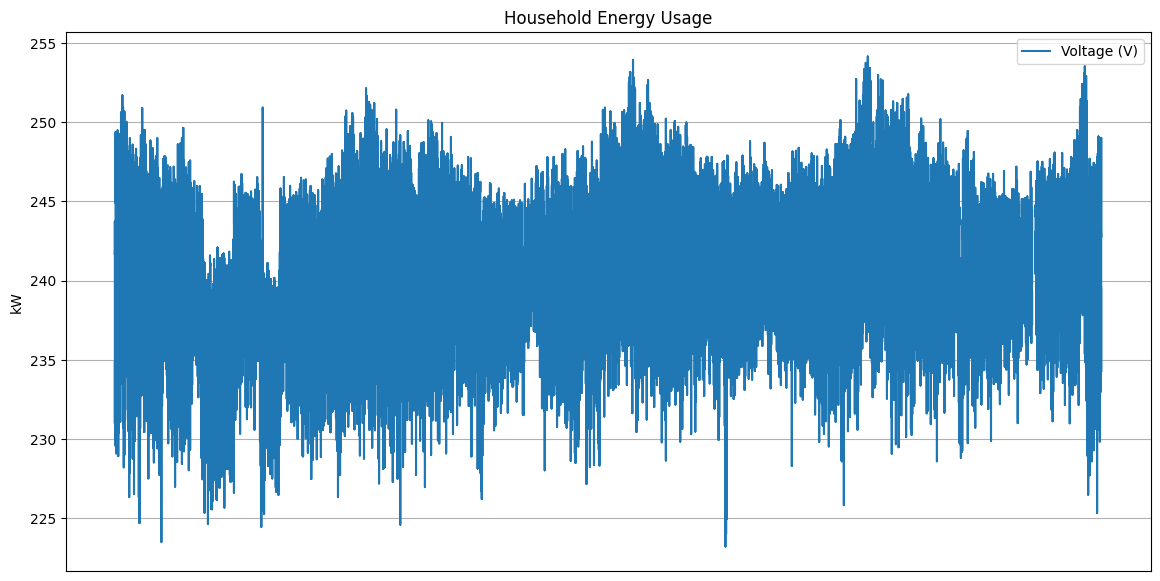

In [19]:
# Plotting the variables
plt.figure(figsize=(14, 7))

plt.plot(data['Date'], data['Voltage'], label='Voltage (V)')

plt.ylabel('kW')
plt.xticks([])  
plt.title('Household Energy Usage')
plt.legend()
plt.grid(True)
plt.show()

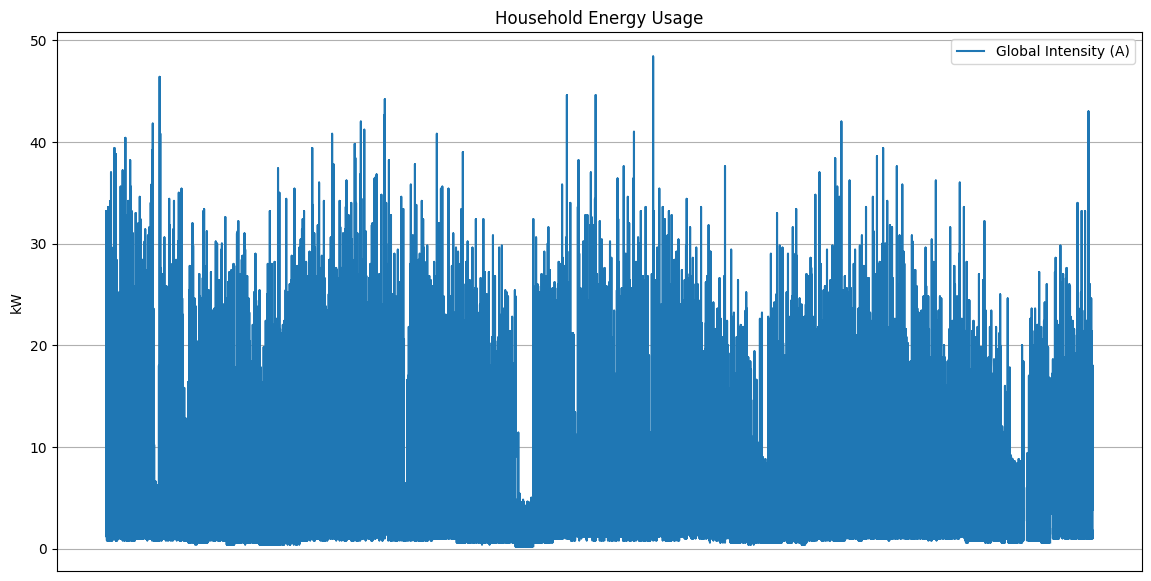

In [20]:
# Plotting the variables
plt.figure(figsize=(14, 7))

plt.plot(data['Date'], data['Global_intensity'], label='Global Intensity (A)')

plt.ylabel('kW')
plt.xticks([])  
plt.title('Household Energy Usage')
plt.legend()
plt.grid(True)
plt.show()

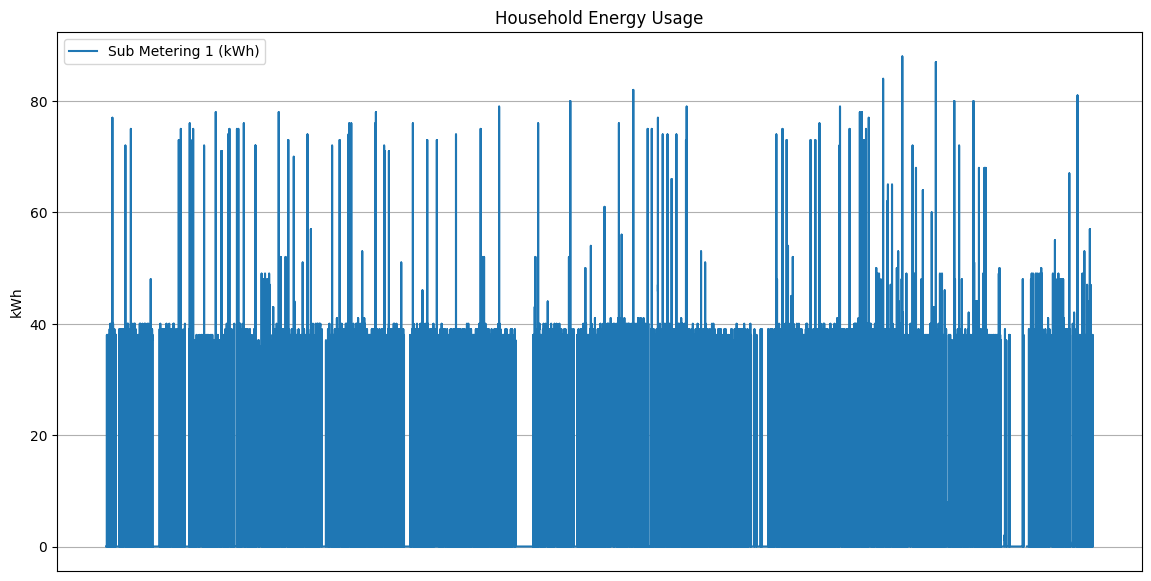

In [21]:
# Plotting the variables
plt.figure(figsize=(14, 7))

plt.plot(data['Date'], data['Sub_metering_1'], label='Sub Metering 1 (kWh)')

plt.ylabel('kWh')
plt.xticks([])  
plt.title('Household Energy Usage')
plt.legend()
plt.grid(True)
plt.show()

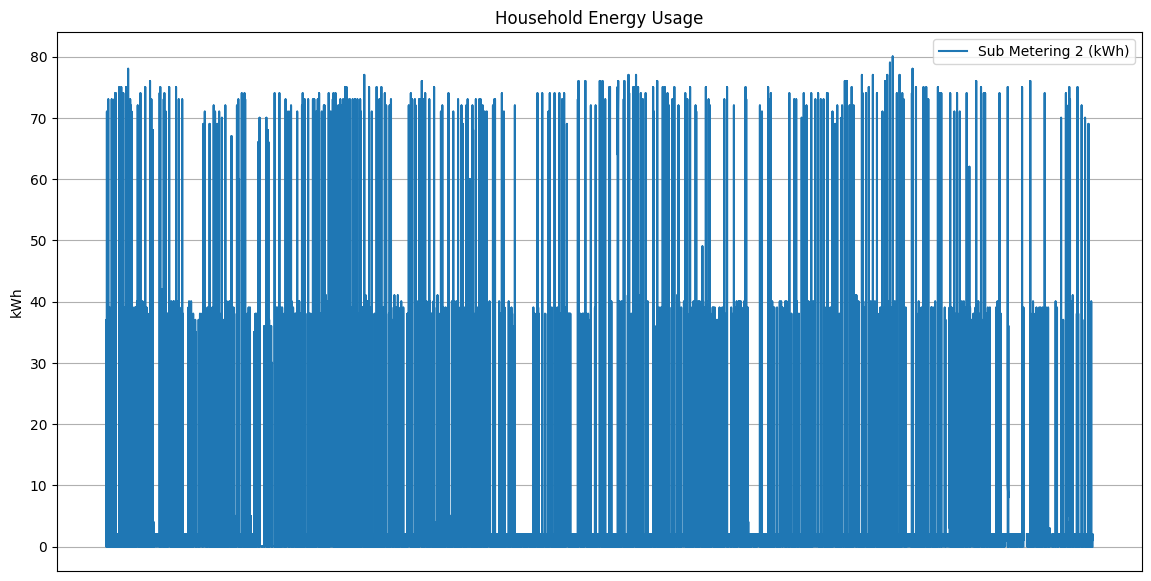

In [22]:
# Plotting the variables
plt.figure(figsize=(14, 7))

plt.plot(data['Date'], data['Sub_metering_2'], label='Sub Metering 2 (kWh)')

plt.ylabel('kWh')
plt.xticks([])  
plt.title('Household Energy Usage')
plt.legend()
plt.grid(True)
plt.show()

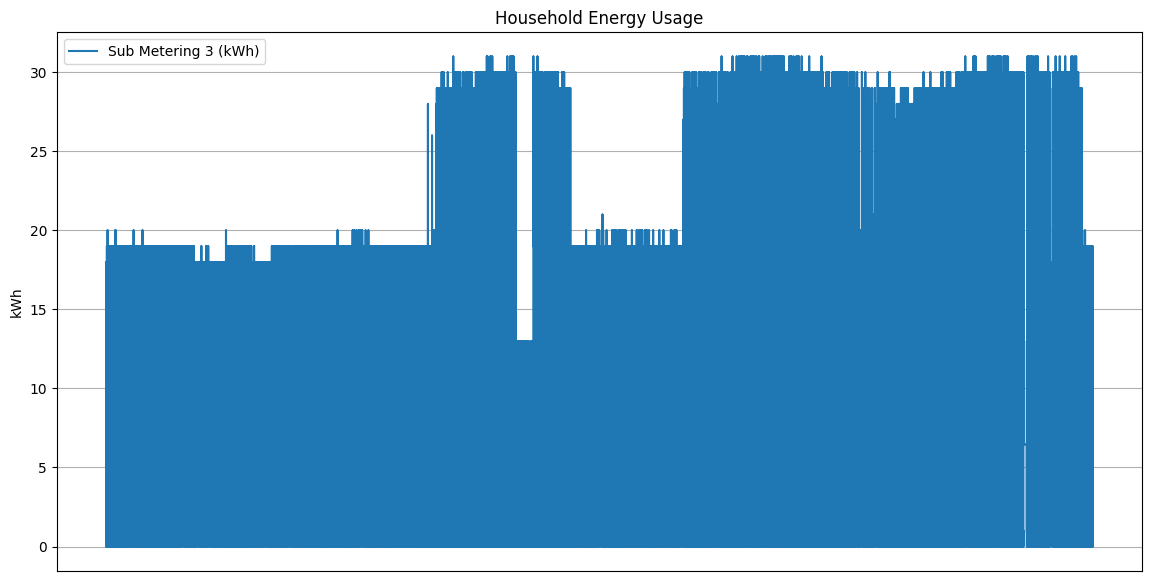

In [23]:
# Plotting the variables
plt.figure(figsize=(14, 7))

plt.plot(data['Date'], data['Sub_metering_3'], label='Sub Metering 3 (kWh)')

plt.ylabel('kWh')
plt.xticks([])  
plt.title('Household Energy Usage')
plt.legend()
plt.grid(True)
plt.show()

If we look closely to the graph, we can see that power usage especially “Global active power” is strongly seasonal dependent.

<Axes: xlabel='Global_active_power', ylabel='Density'>

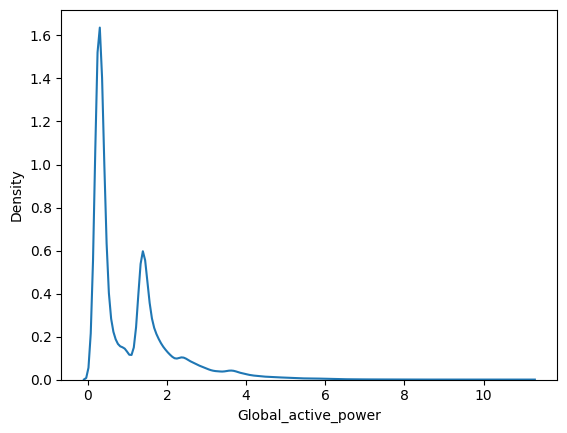

In [24]:
import seaborn as sns

# Make default density plot
sns.kdeplot(data['Global_active_power'])

The distribution of active power seems to be bimodal, which means that it seems to contain two main groups of observations.

We can see that we have many observations for 0 to 500 watts, far fewer between 500 watts and 1 kilowatt and then a higher but steadily decreasing number of observations of over 1 kilowatt.

It could be assumed that this represents two different types of energy consumption:

    The first when no one is at home or the occupants are asleep.
    The second when home appliances are used.

## Model Building

In [10]:
# Convert 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')

# Set 'Date' column as the index
data.set_index('Date', inplace=True)

###  Let's split between training and testing

In [11]:
# Split the data into training and testing sets
train = data[:-2*365]  # Use all data except the last 2 years for training
test = data[-2*365:]   # Use the last 2 years for testing

# Drop the 'Time' column
train = train.drop('Time', axis=1)
test = test.drop('Time', axis=1)

print("Training set shape:", train.shape)
print("Testing set shape:", test.shape)

Training set shape: (2074529, 7)
Testing set shape: (730, 7)


### Now we normalize the data

In [12]:
# Normalize the data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

In [13]:
seq_length = 7

# Function to create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Create sequences for training and testing
X_train, y_train = create_sequences(train_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (2074522, 7, 7)
y_train shape: (2074522, 7)
X_test shape: (723, 7, 7)
y_test shape: (723, 7)


We will be using the TPU in training the model:


In [2]:
import tensorflow as tf

In [3]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


2024-02-21 21:42:40.999307: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-02-21 21:42:40.999419: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-02-21 21:42:40.999496: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-02-21 21:42:40.999568: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-02-21 21:42:40.999651: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-02-21 21:42:40.999845: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-02-21 21:42:40.999920: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this 

INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


REPLICAS:  8


In [19]:
with strategy.scope():
    # Define and compile your LSTM model
    model = Sequential()
    model.add(LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(X_train, y_train, epochs=10, batch_size=32)


/usr/local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10


2024-02-21 23:04:28.819971: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.


 5887/64829 ━━━━━━━━━━━━━━━━━━━━ 6:40 7ms/step - loss: nan

KeyboardInterrupt: 

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [20]:
# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions and actual values
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate the Mean Absolute Error (MAE)
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, predictions)
print("Mean Absolute Error (MAE):", mae)

 1/23 ━━━━━━━━━━━━━━━━━━━━ 16s 746ms/step

2024-02-21 23:06:35.580463: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node sequential_1_1/dense_1_1/Cast/ReadVariableOp.


21/23 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

InvalidArgumentError: Graph execution error:

Detected at node Rank/packed defined at (most recent call last):
  File "/usr/local/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/local/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/usr/local/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/usr/local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/usr/local/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/local/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/local/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/local/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 542, in dispatch_queue

  File "/usr/local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 531, in process_one

  File "/usr/local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/usr/local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 359, in execute_request

  File "/usr/local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 775, in execute_request

  File "/usr/local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 446, in do_execute

  File "/usr/local/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/usr/local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3051, in run_cell

  File "/usr/local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3106, in _run_cell

  File "/usr/local/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3311, in run_cell_async

  File "/usr/local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3493, in run_ast_nodes

  File "/usr/local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipykernel_3711/1407662198.py", line 2, in <module>

  File "/usr/local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 118, in error_handler

  File "/usr/local/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 511, in predict

  File "/usr/local/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 215, in one_step_on_data_distributed

  File "/usr/local/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 770, in reduce_per_replica

  File "/usr/local/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 763, in _reduce

Shapes of all inputs must match: values[0].shape = [3,1] != values[6].shape = [1,1]
	 [[{{node Rank/packed}}]] [Op:__inference_one_step_on_data_distributed_1172011]

In [26]:
def create_int_defaultdict():
    return collections.defaultdict(int)

class A:
  def funA(self):
    #create a dictionary and fill with values
    dictionary = collections.defaultdict(create_int_defaultdict)
    #...
    #then pickle to save it
    pickle.dump(dictionary, f)

In [27]:
pickle.dump(model, open('model.pkl', 'wb'))

AttributeError: Can't pickle local object 'Layer._initializer_tracker.<locals>.<lambda>'

In [24]:
# save the model to disk
filename = 'IDH Power Consuption.sav'
pickle.dump(model, open(filename, 'wb'))

AttributeError: Can't pickle local object 'Layer._initializer_tracker.<locals>.<lambda>'